### Purpose of this notebook:

This notebook will serve as a base for modularizing the llama implementation. First I'll be writing the code in this notebook and then I'll be modularizing it to make it more readable and reusable.

I'll be using the TinyShakespear dataset to test the implementation.

#### Key Takeaways:
Always work iteratively: start small, stay certain and build up!

#### Approach mentioned in the blog:
1. Make all of the helper function required to test your model quanititatively (data splits, training, plotting the loss).
2. Before you even look at the paper, pick a small, simple and fast model that you've done in the past. Then make a helper function to eveluate the model qualitatively.
3. Start by picking apart different components of the paper, and then implement them one-by-one, training and evaluating as you go.

In [3]:
# Loading libraries
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F

In [5]:
import requests

content = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

with open("tinyshakespeare.txt", "w") as f:
    f.write(content.text)

While in Llama they train on 1.4T tokens, our dataset TinyShakespeare, the collection of all shakespeare's works is about 1M chars.

In [6]:
# setting up our dataset
lines = open("tinyshakespeare.txt").read()

vocab = sorted(list(set(lines)))

itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


They use SentencePiece byte-pair encoding tokenizer, but we're going to just use a simple character-level tokenization.

In [7]:
def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return "".join(itos[i] for i in l)

print("vocab size:", len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

First tip: Create a `config` object that stores some basic model params. It makes our code way more readable and removes constants and magic numbers from the code. Add more parameters as needed

In [8]:
MASTER_CONFIG = {
    "vocab_size" : len(vocab),
}

In [10]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

Creating a method to generate our training data and labels for batches. We'll use the same method for validation and test data. 

In [12]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    batch_data = train
    if split == "val":
        batch_data = val
    elif split == "test":
        batch_data = test
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i : i + context_window] for i in ix]).long()
    y = torch.stack([batch_data[i + 1: i + context_window + 1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    "batch_size": 8,
    "context_window": 16
})

xs, ys = get_batches(dataset, "train", MASTER_CONFIG["batch_size"], MASTER_CONFIG["context_window"])
[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[(':\nSuppose, my lo', '\nSuppose, my lor'),
 (" that follow'd\nS", "that follow'd\nSh"),
 ('mple\nOf thousand', 'ple\nOf thousands'),
 (' them burial her', 'them burial here'),
 ('r befall you! he', ' befall you! he '),
 ('ius: it is a\ngen', 'us: it is a\ngent'),
 ('nted to direct t', 'ted to direct th'),
 ('d, with a piece ', ', with a piece o')]

Something interesting written in the blog:

Implementing papers has two aspects to the model working: compilation (do your tensors all match up from layer to layer) and training (do your loss go down). Figuring out how to ensure that each of your, components is working is key to developing your model in a predictable, engineering-minded way.

That's why we're going to define the method for how we're going to evaluate the model. We want do this before we even define the model, because we want to able to use it evaluate the model as we're training it.

In [21]:
@torch.no_grad() # don't compute gradient for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

Setting up a working base model

Here's a basic feed-forward neural network with embeddings. It's the base model we're going to start with and then swap out parts of it as we go along until we eventually end with model as described in Llama.

In [19]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        print("Model Params: ", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)

        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
    
MASTER_CONFIG.update({
    "d_model": 128,
})

model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, "train", MASTER_CONFIG["batch_size"], MASTER_CONFIG["context_window"])

logits, loss = model(xs, ys)

Model Params:  33217


**WE NEED TO START WORRYING ABOUT THE SHAPE OF OUR TENSORS**

When we define the loss:
loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))

We have reshape the logits and targets so that their dimensions match when we compare. We do this with view method. The -1 arguement means "infer this dimenion from others". So in this case we're saying "reshape logits and target to ahve the same number of rows, and however many columns are needed to make that happen". This is a common pattern when you're working with batches of data.

Model Params:  33217


validation loss:  3.9423291444778443


<Axes: >

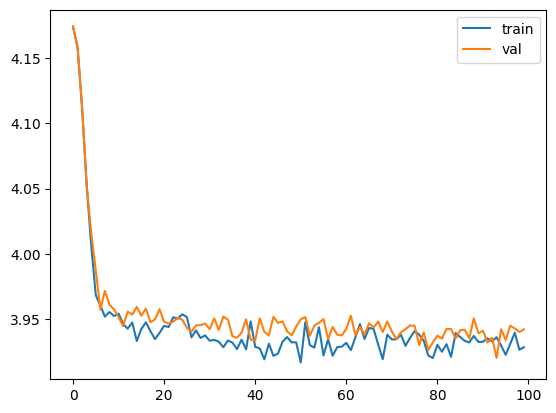

In [32]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

Our training curve barely goes down. The cross-entropy loss before training is 4.17, and after 100 epochs is 3.93.

Cross-entropy in this context is referring to how likely we are to pick the wrong word. So here,
\begin{equation}
    \text{H(T, q)} = -\sum_{i=1}^{N} 1/N {logq(x_i)}
\end{equation}

where $q(x_i)$ is the probability of picking the right word, as estimated by the model. If $q(x_i)$ is close to 1, then $logq$ is close 0; similarly, if q is small then $logq$ is a large negative number, so $-logq$ will be large positive number. Now to build the intuition: to start, $-logq=4.17$, so $q = 0.015$, or around $1/64.715$.







To get an intuition for how the loss relates to the model's performance, think about the model choosing among $\tilde{V}$ tokens; when $\tilde{V}$ is small, the model is more like to guess right. In addition, we know $max \tilde{V} = V$, which can help us understand if our model is learning at all

$$ \tilde{V} = exp(L)$$

In our model we're using softmax layer on our logits, which is a function that takes vector of number and squashes them into a probability distribution. But for using the build in `F.cross_entropy` function, we need pass in the unnormalized logits directly.

Model Params:  33217
validation loss:  2.5085530519485473


<Axes: >

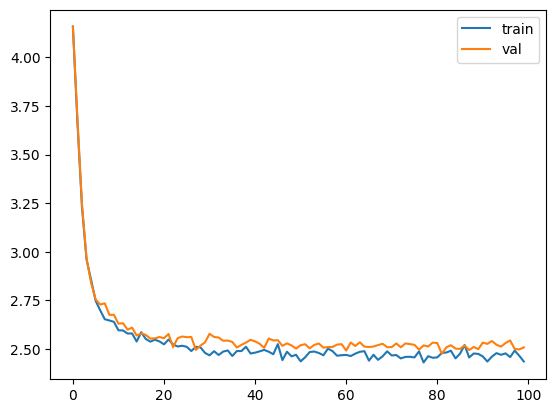

In [33]:
class SimpleModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        print("Model Params: ", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits

model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Great!

Now our loss is going down, it's ~2.54, so we're choosing from 12.67 chars. That's way better than 64 we started with. 

Adding a generate method to our model so we visually see the results of our model

In [34]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']: ])
        last_time_step_logits = logits[
            :, -1, :
        ] # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1) # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        ) # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1) # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\nHelown hatooroion wat d thong ',
 '\nTherivamom d f osessprd stes! ',
 '\n\nARinded adechol.\nFoor sisesth',
 '\nDY a tatharo IINI:\nHAngit r f ',
 "\nI y my mitht,\nWixer mang hr's "]

The output is okayish. But now we have a working model that is training to a validation loss. So here we'll iterate on our model to make it more close to Llama

Llama Specifics:

Llama describes three architectureal modifications to the original transformer:
1. RMSNorm for pre-normalization
2. Rotary embeddings
3. SwiGLU activation function

Adding each one!

In [35]:
# We use RMSNorm which is where you scale the vector by the variance without centering it, we apply to the inputs (prenormalization)

class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter('scale', nn.Parameter(torch.ones(layer_shape)))
    
    def forward(self, x):
        # assumes shape is (batch, seq_len, d_model)
        # frob norm is not the same as RMS. RMS = 1 / sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13
}

batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)

print(g.shape)

torch.Size([5, 11, 13])


Now we do row-wise comparison so that we know that it's doing what's it's supposed to do.

The RMSNorm has the property where the norm of the layer will be super root of the number of elements in the layers, so we can check that forver layer.

In [37]:
rms = torch.linalg.norm(batch, dim=(1, 2)) * (batch[0].numel() ** -.5)

assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]

assert torch.allclose(torch.linalg.norm(ffx, dim=(1, 2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

Model Params:  35265
validation loss:  2.5249350547790526


<Axes: >

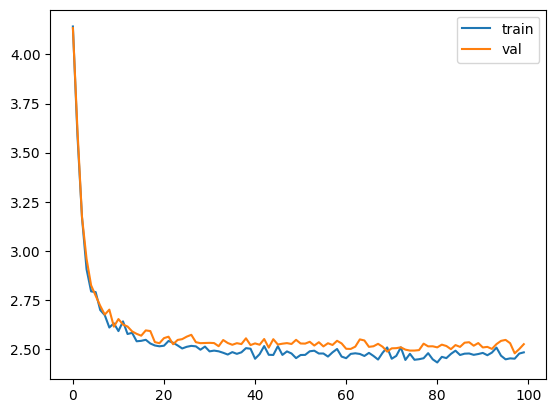

In [38]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        print("Model Params: ", sum([m.numel() for m in self.parameters()]))
    
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        
model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Rotary Embeddings

RoPE is a kind of positional encoding for transformers.

Embedding the position of a token in a sequence by rotating the embedding, with a different rotation at each position.

In [39]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i, 2*i] = np.cos(m_theta)
            R[position, 2*i, 2*i + 1] = -np.sin(m_theta)
            R[position, 2*i + 1, 2*i] = np.sin(m_theta)
            R[position, 2*i + 1, 2*i + 1] = np.cos(m_theta)
    return R

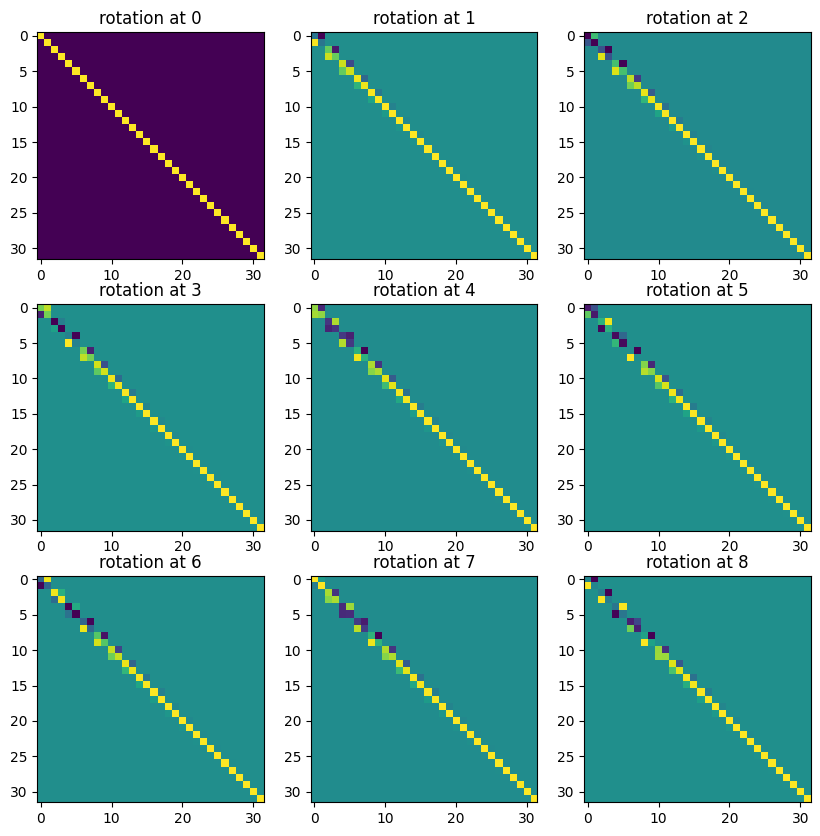

In [40]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2
}

batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(10, 10))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [41]:
config = {
    'd_model': 32,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m, : , :] @ x
x_n = R[n, : , :] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m, :, :] @ y)

In [42]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])
    
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1
        )

        if return_attn_weights:
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

layer = RoPEAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [43]:
print(output.shape)
print(attn_weights.shape)

torch.Size([10, 16, 512])
torch.Size([10, 16, 16])


In [44]:
class RoPEMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

MASTER_CONFIG.update({
    'n_heads': 8,
})

layer = RoPEMultiHeadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

Model Params:  559681
validation loss:  0.1565635085105896


<Axes: >

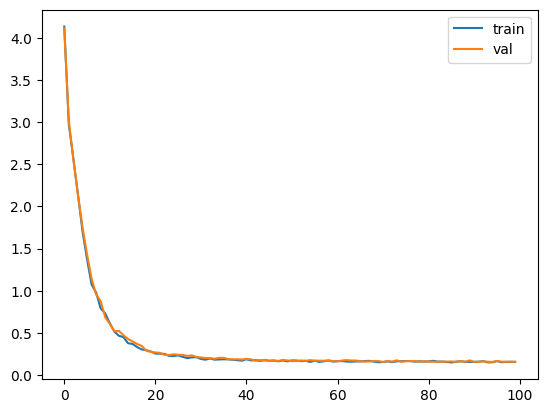

In [45]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMultiHeadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU()
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        print("Model Params: ", sum([m.numel() for m in self.parameters()]))
    
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

DAMN!!!

The val loss is way too low. Let's see how it generates

In [46]:
generate(model, config=MASTER_CONFIG)

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n']

lmao what the heck is this?!?!

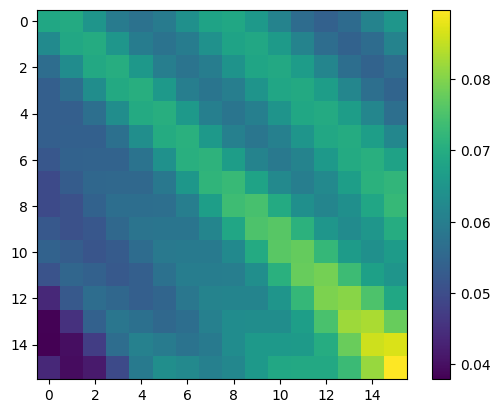

In [49]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()

So here we see that the attention is lit up, meaning that characters in any position are attending to characters in any other position. What's bad about this?

We are trying to predict the next token solely on the tokens that came before it, but we're seeing that the model is attending to tokens that come after it. In other words, the model is cheating, or leaking information from the future. This is a problem and it's we need a causal mask.

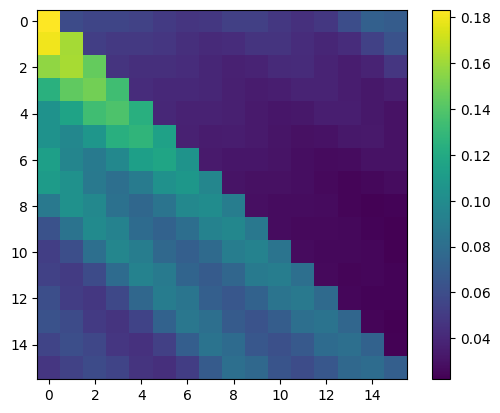

In [51]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

layer = RoPEMaskedAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)
layer = RoPEMaskedAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

Now, we can see that the upper triangular of our attention activation (the part that corresponds to the future) is nearly zeroed out

In [52]:
class RoPEMaskedMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)
    
    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

MASTER_CONFIG.update({
    'n_heads': 8,
})

layer = RoPEMaskedMultiHeadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

Model Params:  559681
validation loss:  2.052293634414673


<Axes: >

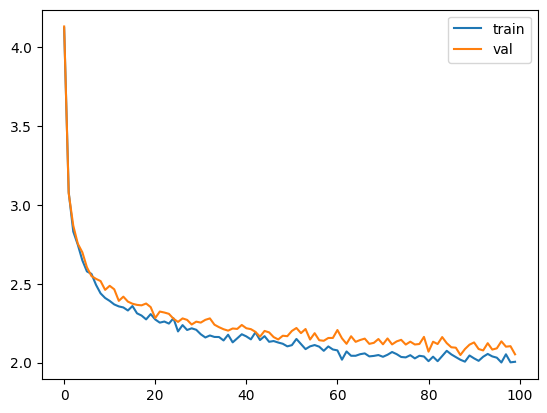

In [53]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiHeadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU()
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        print("Model Params: ", sum([m.numel() for m in self.parameters()]))
    
    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)
        
        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Our loss is now not merely dropping to near-zero. It looks like we can drive our loss down even lower

validation loss:  1.9022066950798036


<Axes: >

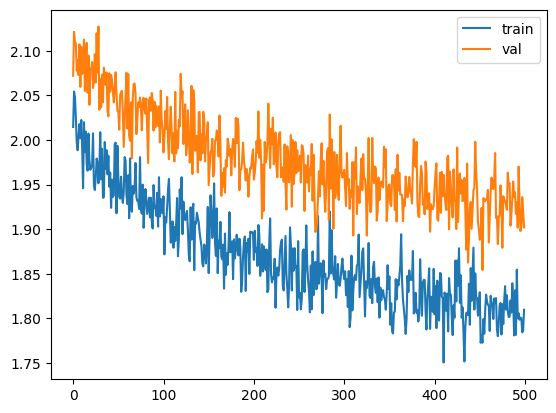

In [54]:
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})
train(model, optimizer)